In [1]:
import json
import torch
import torch.nn as nn
import torch.utils.data
import math
import torch.nn.functional as F
import neptune
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from collections import Counter
from torchinfo import summary
from sklearn.decomposition import PCA
from torch.utils.data import Dataset

In [2]:
# knowledgebase_url = 'https://github.com/AndiAlifs/FLUENT-Chatbot-2023/raw/main/KnowledgeBaseFilkom.xlsx'
knowledgebase_url = 'https://github.com/AndiAlifs/FLUENT-Chatbot-2023/raw/main/KnowledgeBaseFilkom_simple.xlsx'
knowledgebase = pd.read_excel(knowledgebase_url)

qa_paired = knowledgebase.drop(columns=knowledgebase.columns.drop(['Pertanyaan', 'Jawaban']))
qa_paired.dropna(inplace=True)
qa_paired

,Pertanyaan,Jawaban
0,visi filkom,menjadi fakultas yang berdaya saing internasio...
1,misi filkom,menyelenggarakan pendidikan di bidang teknolog...
2,apa tujuan filkom?,"menghasilkan lulusan yang kompeten , profesion..."
3,sasaran pendidikan filkom,meningkatkan kompetensi dan kualifikasi pendid...
4,email fitra a. bachtiar,fitra.bachtiar[at]ub.ac.id
5,bidang penelitian fitra a. bachtiar,"affective computing, affective engineering, in..."
6,tanggal dibentuk ptiik,27 oktober 2011
7,sasaran pengabdian filkom,1. meningkatkan kualitas dan kuantitas pengabd...
8,sasaran kerjasama filkom,"1. mengadakan kerjasama pendidikan, penlitian ..."
9,dekan fakultas ilmu komputer filkom,"prof. ir. wayan firdaus mahmudy, s.si., mt., p..."


In [3]:
def remove_punc(string):
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~1234567890'''
    no_punct = ""
    for char in string:
        if char not in punctuations:
            no_punct = no_punct + char  # space is also a character
    return no_punct.lower()

In [4]:
pairs = []
max_len = 90

for line in qa_paired.iterrows():
    pertanyaan = line[1]['Pertanyaan']
    jawaban = line[1]['Jawaban']
    qa_pairs = []
    first = remove_punc(pertanyaan.strip())      
    second = remove_punc(jawaban.strip())

    if len(first) == 0 or len(second) == 0:
        continue

    
    qa_pairs.append(first.split()[:max_len])
    qa_pairs.append(second.split()[:max_len])
    pairs.append(qa_pairs)

In [5]:
pairs_df = pd.DataFrame(pairs, columns=['question', 'answer'])
pairs_df

,question,answer
0,"[visi, filkom]","[menjadi, fakultas, yang, berdaya, saing, inte..."
1,"[misi, filkom]","[menyelenggarakan, pendidikan, di, bidang, tek..."
2,"[apa, tujuan, filkom]","[menghasilkan, lulusan, yang, kompeten, profes..."
3,"[sasaran, pendidikan, filkom]","[meningkatkan, kompetensi, dan, kualifikasi, p..."
4,"[email, fitra, a, bachtiar]",[fitrabachtiaratubacid]
5,"[bidang, penelitian, fitra, a, bachtiar]","[affective, computing, affective, engineering,..."
6,"[tanggal, dibentuk, ptiik]",[oktober]
7,"[sasaran, pengabdian, filkom]","[meningkatkan, kualitas, dan, kuantitas, penga..."
8,"[sasaran, kerjasama, filkom]","[mengadakan, kerjasama, pendidikan, penlitian,..."
9,"[dekan, fakultas, ilmu, komputer, filkom]","[prof, ir, wayan, firdaus, mahmudy, ssi, mt, phd]"


In [6]:
word_freq = Counter()
for pair in pairs:
    word_freq.update(pair[0])
    word_freq.update(pair[1])

In [7]:
min_word_freq = 0
words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
word_map = {k: v + 1 for v, k in enumerate(words)}
word_map['<unk>'] = len(word_map) + 1
word_map['<start>'] = len(word_map) + 1
word_map['<end>'] = len(word_map) + 1
word_map['<pad>'] = 0

In [8]:
print("Total words are: {}".format(len(word_map)))

Total words are: 440


In [9]:
with open('WORDMAP_corpus_KBFILKOM.json', 'w') as j:
    json.dump(word_map, j)

In [10]:
def encode_question(words, word_map):
    enc_c = [word_map.get(word, word_map['<unk>']) for word in words] + [word_map['<pad>']] * (max_len - len(words))
    return enc_c


def encode_question_left(words, word_map):
    enc_c = [word_map['<pad>']] * (max_len - len(words)) + [word_map.get(word, word_map['<unk>']) for word in words]
    return enc_c

def encode_reply(words, word_map):
    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in words] + \
    [word_map['<end>']] + [word_map['<pad>']] * (max_len - len(words))
    return enc_c

def encode_reply_with_maxlen(words, word_map):
    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in words] + [word_map['<end>']] + [word_map['<pad>']] * (max_len-2 - len(words))
    return enc_c

In [11]:
pairs_encoded = []
for pair in pairs:
    qus = encode_question(pair[0], word_map)
    # qus = encode_question_left(pair[0], word_map)
    ans = encode_reply(pair[1], word_map)
    pairs_encoded.append([qus, ans])

with open('pairs_encoded_kbfilkom.json', 'w') as p:
    json.dump(pairs_encoded, p)

In [12]:
class Dataset(Dataset):

    def __init__(self):

        self.pairs = json.load(open('pairs_encoded_kbfilkom.json'))
        self.dataset_size = len(self.pairs)

    def __getitem__(self, i):
        
        question = torch.LongTensor(self.pairs[i][0])
        reply = torch.LongTensor(self.pairs[i][1])
            
        return question, reply

    def __len__(self):
        return self.dataset_size

## Train Loader

In [13]:
train_loader = torch.utils.data.DataLoader(Dataset(),
                                           batch_size = 100, 
                                           shuffle=True, 
                                           pin_memory=True)

In [14]:
def create_masks(question, reply_input, reply_target):
    
    def subsequent_mask(size):
        mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
        return mask.unsqueeze(0)
    
    question_mask = question!=0
    question_mask = question_mask.to(device)
    question_mask = question_mask.unsqueeze(1).unsqueeze(1)         # (batch_size, 1, 1, max_words)
     
    reply_input_mask = reply_input!=0
    reply_input_mask = reply_input_mask.unsqueeze(1)  # (batch_size, 1, max_words)
    reply_input_mask = reply_input_mask & subsequent_mask(reply_input.size(-1)).type_as(reply_input_mask.data) 
    reply_input_mask = reply_input_mask.unsqueeze(1) # (batch_size, 1, max_words, max_words)
    reply_target_mask = reply_target!=0              # (batch_size, max_words)
    
    return question_mask, reply_input_mask, reply_target_mask

In [15]:
import os

def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Directory created at {path}")
    else:
        print(f"Directory already exists at {path}")

# Architecture

## Embeddings

In [16]:
class Embeddings(nn.Module):
    """
    Implements embeddings of the words and adds their positional encodings. 
    """
    def __init__(self, vocab_size, d_model, max_len = 50, num_layers = 6):
        super(Embeddings, self).__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(0.1)
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pe = self.create_positinal_encoding(max_len, self.d_model)     # (1, max_len, d_model)
        self.te = self.create_positinal_encoding(num_layers, self.d_model)  # (1, num_layers, d_model)
        self.dropout = nn.Dropout(0.1)
        
    def create_positinal_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model).to(device)
        for pos in range(max_len):   # for each position of the word
            for i in range(0, d_model, 2):   # for each dimension of the each position
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        pe = pe.unsqueeze(0)   # include the batch size
        return pe
        
    def forward(self, embedding, layer_idx):
        if layer_idx == 0:
            embedding = self.embed(embedding) * math.sqrt(self.d_model)
        embedding += self.pe[:, :embedding.size(1)]   # pe will automatically be expanded with the same batch size as encoded_words
        # embedding: (batch_size, max_len, d_model), te: (batch_size, 1, d_model)
        embedding += self.te[:, layer_idx, :].unsqueeze(1).repeat(1, embedding.size(1), 1)
        embedding = self.dropout(embedding)
        return embedding

## Multi-Head Attention

In [17]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, heads, d_model):
        super(MultiHeadAttention, self).__init__()
        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = nn.Dropout(0.1)
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.concat = nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask):
        """
        query, key, value of shape: (batch_size, max_len, 512)
        mask of shape: (batch_size, 1, 1, max_words)
        """
        # (batch_size, max_len, 512)
        query = self.query(query)
        key = self.key(key)        
        value = self.value(value)   
        
        # (batch_size, max_len, 512) --> (batch_size, max_len, h, d_k) --> (batch_size, h, max_len, d_k)
        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)   
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        
        # (batch_size, h, max_len, d_k) matmul (batch_size, h, d_k, max_len) --> (batch_size, h, max_len, max_len)
        scores = torch.matmul(query, key.permute(0,1,3,2)) / math.sqrt(query.size(-1))
        scores = scores.masked_fill(mask == 0, -1e9)    # (batch_size, h, max_len, max_len)
        weights = F.softmax(scores, dim = -1)           # (batch_size, h, max_len, max_len)
        weights = self.dropout(weights)
        # (batch_size, h, max_len, max_len) matmul (batch_size, h, max_len, d_k) --> (batch_size, h, max_len, d_k)
        context = torch.matmul(weights, value)
        # (batch_size, h, max_len, d_k) --> (batch_size, max_len, h, d_k) --> (batch_size, max_len, h * d_k)
        context = context.permute(0,2,1,3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)
        # (batch_size, max_len, h * d_k)
        interacted = self.concat(context)
        return interacted 

## Feed Forward Neural Network

In [18]:
class FeedForward(nn.Module):
    def __init__(self, d_model, middle_dim = 2048):
        super(FeedForward, self).__init__()
        
        self.fc1 = nn.Linear(d_model, middle_dim)
        self.fc2 = nn.Linear(middle_dim, d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out


## Encoder

In [19]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, embeddings, mask):
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        interacted = self.layernorm(interacted + embeddings)
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded

## Decoder

In [20]:
class DecoderLayer(nn.Module):
    
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadAttention(heads, d_model)
        self.src_multihead = MultiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, embeddings, encoded, src_mask, target_mask):
        query = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, target_mask))
        query = self.layernorm(query + embeddings)
        interacted = self.dropout(self.src_multihead(query, encoded, encoded, src_mask))
        interacted = self.layernorm(interacted + query)
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        decoded = self.layernorm(feed_forward_out + interacted)
        return decoded


## Transformer Architecture

In [21]:
class Transformer(nn.Module):
    
    def __init__(self, d_model, heads, num_layers_enc, num_layers_dec, word_map, max_len = 50):
        super(Transformer, self).__init__()
        
        self.d_model = d_model
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.vocab_size = len(word_map)
        self.embed_enc = Embeddings(self.vocab_size, d_model, num_layers = num_layers_enc, max_len = max_len)
        self.embed_dec = Embeddings(self.vocab_size, d_model, num_layers = num_layers_dec, max_len = max_len)
        self.encoder = EncoderLayer(d_model, heads) 
        self.decoder = DecoderLayer(d_model, heads)
        self.logit = nn.Linear(d_model, self.vocab_size)
        
    def encode(self, src_embeddings, src_mask):
        for i in range(self.num_layers_enc):
            src_embeddings = self.embed_enc(src_embeddings, i)
            src_embeddings = self.encoder(src_embeddings, src_mask)
        return src_embeddings
    
    def decode(self, tgt_embeddings, target_mask, src_embeddings, src_mask):
        for i in range(self.num_layers_enc):
            tgt_embeddings = self.embed_enc(tgt_embeddings, i)
            tgt_embeddings = self.decoder(tgt_embeddings, src_embeddings, src_mask, target_mask)
        return tgt_embeddings
        
    def forward(self, src_words, src_mask, target_words, target_mask):
        encoded = self.encode(src_words, src_mask)
        print("size of encoded", encoded.size())
        decoded = self.decode(target_words, target_mask, encoded, src_mask)
        out = F.log_softmax(self.logit(decoded), dim = 2)
        return out


In [22]:
class AdamWarmup:
    
    def __init__(self, model_size, warmup_steps, optimizer):
        
        self.model_size = model_size
        self.warmup_steps = warmup_steps
        self.optimizer = optimizer
        self.current_step = 0
        self.lr = 0
        
    def get_lr(self):
        return self.model_size ** (-0.5) * min(self.current_step ** (-0.5), self.current_step * self.warmup_steps ** (-1.5))
        
    def step(self):
        # Increment the number of steps each time we call the step function
        self.current_step += 1
        lr = self.get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        # update the learning rate
        self.lr = lr
        self.optimizer.step()       
        

In [23]:
class LossWithLS(nn.Module):

    def __init__(self, size, smooth):
        super(LossWithLS, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False, reduce=False)
        self.confidence = 1.0 - smooth
        self.smooth = smooth
        self.size = size
        
    def forward(self, prediction, target, mask):
        """
        prediction of shape: (batch_size, max_words, vocab_size)
        target and mask of shape: (batch_size, max_words)
        """
        prediction = prediction.view(-1, prediction.size(-1))   # (batch_size * max_words, vocab_size)
        target = target.contiguous().view(-1)   # (batch_size * max_words)
        mask = mask.float()
        mask = mask.view(-1)       # (batch_size * max_words)
        labels = prediction.data.clone()
        labels.fill_(self.smooth / (self.size - 1))
        labels.scatter_(1, target.data.unsqueeze(1), self.confidence)
        loss = self.criterion(prediction, labels)    # (batch_size * max_words, vocab_size)
        loss = (loss.sum(1) * mask).sum() / mask.sum()
        return loss
        

# Define Neptune Experiment

In [24]:
project = "andialifs/fluent-tesis-playground-24"
api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjZTY2YWQ3My04OTBkLTQ2OWUtYTc1Ni1jYjk0MGZhMWFiNGEifQ=="

def neptune_init(name="cobain"):
    run = neptune.init_run(
        project=project,
        api_token=api_token,
        name=name
    )
    return run

# Function

In [28]:
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu(preds, questions, answers):
    bleu_score_1 = 0
    bleu_score_2 = 0
    bleu_score_3 = 0
    bleu_score_4 = 0
    bleu_score_all = 0

    num_of_rows_calculated = 0

    for i, (question, real_answer) in enumerate(zip(questions, answers)):
        # print(f"Question: {question}")
        # print(f"Real Answer: {real_answer}")
        # print(f"Predicted Answer: {preds[i]}")
        try:
            refs = [real_answer.split(' ')]
            hyp = preds[i].split(' ')

            bleu_score_1 += sentence_bleu(refs, hyp, weights=(1,0,0,0))
            bleu_score_2 += sentence_bleu(refs, hyp, weights=(0,1,0,0))
            bleu_score_3 += sentence_bleu(refs, hyp, weights=(0,0,1,0))
            bleu_score_4 += sentence_bleu(refs, hyp, weights=(0,0,0,1))
            bleu_score_all += sentence_bleu(refs, hyp, weights=(.25,.25,.25,.25))

            num_of_rows_calculated+=1
        except:
            continue

    results = {"1-gram": (bleu_score_1/num_of_rows_calculated),
                "2-gram": (bleu_score_2/num_of_rows_calculated),
                "3-gram": (bleu_score_3/num_of_rows_calculated),
                "4-gram": (bleu_score_all/num_of_rows_calculated)}
    
    return results

## Train

In [25]:
def train(train_loader, transformer, criterion, epoch):
    transformer.train()
    sum_loss = 0
    count = 0

    for i, (question, reply) in enumerate(train_loader):
        
        samples = question.shape[0]

        # Move to device
        question = question.to(device)
        reply = reply.to(device)

        # Prepare Target Data
        reply_input = reply[:, :-1]
        reply_target = reply[:, 1:]

        # Create mask and add dimensions
        question_mask, reply_input_mask, reply_target_mask = create_masks(question, reply_input, reply_target)

        # Get the transformer outputs
        out = transformer(question, question_mask, reply_input, reply_input_mask)

        # Compute the loss
        loss = criterion(out, reply_target, reply_target_mask)
        
        # Backprop
        transformer_optimizer.optimizer.zero_grad()
        loss.backward()
        transformer_optimizer.step()
        
        sum_loss += loss.item() * samples
        count += samples
        
        if i % 100 == 0:
            print("Epoch [{}][{}/{}]\tLoss: {:.3f}".format(epoch, i, len(train_loader), sum_loss/count))
    
    return sum_loss/count

## Evaluate

In [26]:
def evaluate(transformer, question, question_mask, max_len, word_map):
    """
    Performs Greedy Decoding with a batch size of 1
    """
    rev_word_map = {v: k for k, v in word_map.items()}
    transformer.eval()
    start_token = word_map['<start>']
    encoded = transformer.encode(question, question_mask)
    words = torch.LongTensor([[start_token]]).to(device)
    
    for step in range(max_len - 1):
        size = words.shape[1]
        target_mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
        target_mask = target_mask.to(device).unsqueeze(0).unsqueeze(0)
        decoded = transformer.decode(words, target_mask, encoded, question_mask)
        predictions = transformer.logit(decoded[:, -1])
        _, next_word = torch.max(predictions, dim = 1)
        next_word = next_word.item()
        if next_word == word_map['<end>']:
            break
        words = torch.cat([words, torch.LongTensor([[next_word]]).to(device)], dim = 1)   # (1,step+2)
        
    # Construct Sentence
    if words.dim() == 2:
        words = words.squeeze(0)
        words = words.tolist()
        
    sen_idx = [w for w in words if w not in {word_map['<start>']}]
    sentence = ' '.join([rev_word_map[sen_idx[k]] for k in range(len(sen_idx))])
    
    return sentence

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Experiment

## Transformers without reg

In [29]:
d_model = [512, 1024, 2048, 4096]
encoder_layers = [1, 3, 5]
decoder_layers = [1, 3, 5]
heads = [4, 8, 16, 32]
epochs = 150

torch.cuda.empty_cache()

directory = 'experiment_siet24_288'
create_directory(directory)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open('WORDMAP_corpus_KBFILKOM.json', 'r') as j:
    word_map = json.load(j)

transformer_experiment = pd.DataFrame(columns = ['experiment_id', 'd_model', 'heads', 'num_layers', 'train_loss'])

experiment_id = -1

torch.cuda.empty_cache()

for d_m in d_model:
    for h in heads:
        for n_l1 in encoder_layers:
            for n_l2 in decoder_layers: 
                experiment_id += 1

                if experiment_id < 79:
                    print('Skipping experiment {}'.format(experiment_id))
                    continue
                
                print('\nRunning for experiment {} with d_model {}, heads{}, num_layers_enc {}, num_layers_dec {}\n'.format(experiment_id, d_m, h, n_l1, n_l2))
                name = directory + str(experiment_id)

                run = neptune_init(name)
                
                transformer_experiment.loc[experiment_id, 'experiment_id'] = 'experiment_{}'.format(str(experiment_id))
                transformer_experiment.loc[experiment_id, 'd_model'] = d_m
                transformer_experiment.loc[experiment_id, 'heads'] = h
                transformer_experiment.loc[experiment_id, 'decoder_layers'] = n_l2
                transformer_experiment.loc[experiment_id, 'encoder_layers'] = n_l1

                transformer = Transformer(d_model = d_m, 
                                            heads = h, 
                                            num_layers_enc=n_l1, 
                                            num_layers_dec=n_l2,
                                            word_map = word_map, 
                                            max_len=95
                                        )
                transformer = transformer.to(device)
                adam_optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
                transformer_optimizer = AdamWarmup(model_size = d_m, warmup_steps = 4000, optimizer = adam_optimizer)
                criterion = LossWithLS(len(word_map), 0.2)

                loss_list_experiment = []
                for epoch in range(epochs):
                    loss_train = train(train_loader, transformer, criterion, epoch)

                    state = {'epoch': epoch, 'transformer': transformer, 'transformer_optimizer': transformer_optimizer}

                    loss_list_experiment.append(loss_train)

                    run['train/loss'].append(loss_train)

                save_dir = directory + '/experiment_' + str(experiment_id) + '.pth.tar'
                parameters = {
                    'd_model': d_m,
                    'heads': h,
                    'encoder_layers': n_l1,
                    'decoder_layers': n_l2,
                    'model_dir': save_dir,
                    'total_params': summary(transformer).trainable_params
                }
                run['parameters'] = parameters
                
                torch.save(state, save_dir)

                transformer_experiment.loc[experiment_id, 'train_loss'] = loss_train

                with open(directory + 'loss_history.yaml', 'w') as file:
                    yaml.dump(loss_list_experiment, file)
                
                run.stop()


Directory already exists at experiment_siet24_288
Skipping experiment 0
Skipping experiment 1
Skipping experiment 2
Skipping experiment 3
Skipping experiment 4
Skipping experiment 5
Skipping experiment 6
Skipping experiment 7
Skipping experiment 8
Skipping experiment 9
Skipping experiment 10
Skipping experiment 11
Skipping experiment 12
Skipping experiment 13
Skipping experiment 14
Skipping experiment 15
Skipping experiment 16
Skipping experiment 17
Skipping experiment 18
Skipping experiment 19
Skipping experiment 20
Skipping experiment 21
Skipping experiment 22
Skipping experiment 23
Skipping experiment 24
Skipping experiment 25
Skipping experiment 26
Skipping experiment 27
Skipping experiment 28
Skipping experiment 29
Skipping experiment 30
Skipping experiment 31
Skipping experiment 32
Skipping experiment 33
Skipping experiment 34
Skipping experiment 35
Skipping experiment 36
Skipping experiment 37
Skipping experiment 38
Skipping experiment 39
Skipping experiment 40
Skipping experime

[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/andialifs/siet-24/e/SIET-104


/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.935
Epoch [1][0/12]	Loss: 5.828
Epoch [2][0/12]	Loss: 5.520
Epoch [3][0/12]	Loss: 5.331
Epoch [4][0/12]	Loss: 5.165
Epoch [5][0/12]	Loss: 4.859
Epoch [6][0/12]	Loss: 4.788
Epoch [7][0/12]	Loss: 4.743
Epoch [8][0/12]	Loss: 4.612
Epoch [9][0/12]	Loss: 4.655
Epoch [10][0/12]	Loss: 4.605
Epoch [11][0/12]	Loss: 4.580
Epoch [12][0/12]	Loss: 4.466
Epoch [13][0/12]	Loss: 4.463
Epoch [14][0/12]	Loss: 4.618
Epoch [15][0/12]	Loss: 4.486
Epoch [16][0/12]	Loss: 4.140
Epoch [17][0/12]	Loss: 4.358
Epoch [18][0/12]	Loss: 4.109
Epoch [19][0/12]	Loss: 4.053
Epoch [20][0/12]	Loss: 3.954
Epoch [21][0/12]	Loss: 3.694
Epoch [22][0/12]	Loss: 3.606
Epoch [23][0/12]	Loss: 3.390
Epoch [24][0/12]	Loss: 3.612
Epoch [25][0/12]	Loss: 3.277
Epoch [26][0/12]	Loss: 2.925
Epoch [27][0/12]	Loss: 3.166
Epoch [28][0/12]	Loss: 3.443
Epoch [29][0/12]	Loss: 3.311
Epoch [30][0/12]	Loss: 2.850
Epoch [31][0/12]	Loss: 2.854
Epoch [32][0/12]	Loss: 2.833
Epoch [33][0/12]	Loss: 2.691
Epoch [34][0/12]	Loss: 2

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.981
Epoch [1][0/12]	Loss: 5.901
Epoch [2][0/12]	Loss: 5.609
Epoch [3][0/12]	Loss: 5.316
Epoch [4][0/12]	Loss: 5.158
Epoch [5][0/12]	Loss: 4.980
Epoch [6][0/12]	Loss: 4.832
Epoch [7][0/12]	Loss: 4.777
Epoch [8][0/12]	Loss: 4.831
Epoch [9][0/12]	Loss: 4.623
Epoch [10][0/12]	Loss: 4.529
Epoch [11][0/12]	Loss: 4.489
Epoch [12][0/12]	Loss: 4.630
Epoch [13][0/12]	Loss: 4.643
Epoch [14][0/12]	Loss: 4.506
Epoch [15][0/12]	Loss: 4.431
Epoch [16][0/12]	Loss: 4.330
Epoch [17][0/12]	Loss: 4.104
Epoch [18][0/12]	Loss: 4.021
Epoch [19][0/12]	Loss: 4.249
Epoch [20][0/12]	Loss: 3.793
Epoch [21][0/12]	Loss: 3.870
Epoch [22][0/12]	Loss: 3.588
Epoch [23][0/12]	Loss: 3.436
Epoch [24][0/12]	Loss: 3.272
Epoch [25][0/12]	Loss: 3.153
Epoch [26][0/12]	Loss: 3.393
Epoch [27][0/12]	Loss: 3.538
Epoch [28][0/12]	Loss: 2.975
Epoch [29][0/12]	Loss: 3.287
Epoch [30][0/12]	Loss: 2.785
Epoch [31][0/12]	Loss: 2.481
Epoch [32][0/12]	Loss: 2.491
Epoch [33][0/12]	Loss: 2.399
Epoch [34][0/12]	Loss: 2

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.930
Epoch [1][0/12]	Loss: 5.912
Epoch [2][0/12]	Loss: 5.851
Epoch [3][0/12]	Loss: 5.776
Epoch [4][0/12]	Loss: 5.699
Epoch [5][0/12]	Loss: 5.589
Epoch [6][0/12]	Loss: 5.384
Epoch [7][0/12]	Loss: 5.157
Epoch [8][0/12]	Loss: 4.878
Epoch [9][0/12]	Loss: 4.804
Epoch [10][0/12]	Loss: 4.543
Epoch [11][0/12]	Loss: 4.391
Epoch [12][0/12]	Loss: 4.259
Epoch [13][0/12]	Loss: 4.052
Epoch [14][0/12]	Loss: 3.934
Epoch [15][0/12]	Loss: 3.883
Epoch [16][0/12]	Loss: 3.535
Epoch [17][0/12]	Loss: 3.448
Epoch [18][0/12]	Loss: 3.599
Epoch [19][0/12]	Loss: 3.413
Epoch [20][0/12]	Loss: 3.485
Epoch [21][0/12]	Loss: 2.887
Epoch [22][0/12]	Loss: 2.624
Epoch [23][0/12]	Loss: 2.727
Epoch [24][0/12]	Loss: 2.731
Epoch [25][0/12]	Loss: 2.922
Epoch [26][0/12]	Loss: 2.424
Epoch [27][0/12]	Loss: 2.439
Epoch [28][0/12]	Loss: 2.193
Epoch [29][0/12]	Loss: 2.336
Epoch [30][0/12]	Loss: 1.804
Epoch [31][0/12]	Loss: 1.854
Epoch [32][0/12]	Loss: 1.888
Epoch [33][0/12]	Loss: 2.110
Epoch [34][0/12]	Loss: 1

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.956
Epoch [1][0/12]	Loss: 5.926
Epoch [2][0/12]	Loss: 5.879
Epoch [3][0/12]	Loss: 5.807
Epoch [4][0/12]	Loss: 5.690
Epoch [5][0/12]	Loss: 5.538
Epoch [6][0/12]	Loss: 5.396
Epoch [7][0/12]	Loss: 5.174
Epoch [8][0/12]	Loss: 4.920
Epoch [9][0/12]	Loss: 4.879
Epoch [10][0/12]	Loss: 4.489
Epoch [11][0/12]	Loss: 4.113
Epoch [12][0/12]	Loss: 4.440
Epoch [13][0/12]	Loss: 4.119
Epoch [14][0/12]	Loss: 3.918
Epoch [15][0/12]	Loss: 3.953
Epoch [16][0/12]	Loss: 3.678
Epoch [17][0/12]	Loss: 3.585
Epoch [18][0/12]	Loss: 3.398
Epoch [19][0/12]	Loss: 3.302
Epoch [20][0/12]	Loss: 3.104
Epoch [21][0/12]	Loss: 2.903
Epoch [22][0/12]	Loss: 3.027
Epoch [23][0/12]	Loss: 2.695
Epoch [24][0/12]	Loss: 2.569
Epoch [25][0/12]	Loss: 2.808
Epoch [26][0/12]	Loss: 2.395
Epoch [27][0/12]	Loss: 2.295
Epoch [28][0/12]	Loss: 2.506
Epoch [29][0/12]	Loss: 2.367
Epoch [30][0/12]	Loss: 2.131
Epoch [31][0/12]	Loss: 2.037
Epoch [32][0/12]	Loss: 1.927
Epoch [33][0/12]	Loss: 1.602
Epoch [34][0/12]	Loss: 1

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.957
Epoch [1][0/12]	Loss: 5.948
Epoch [2][0/12]	Loss: 5.862
Epoch [3][0/12]	Loss: 5.762
Epoch [4][0/12]	Loss: 5.666
Epoch [5][0/12]	Loss: 5.585
Epoch [6][0/12]	Loss: 5.305
Epoch [7][0/12]	Loss: 5.082
Epoch [8][0/12]	Loss: 4.899
Epoch [9][0/12]	Loss: 4.671
Epoch [10][0/12]	Loss: 4.521
Epoch [11][0/12]	Loss: 4.368
Epoch [12][0/12]	Loss: 4.229
Epoch [13][0/12]	Loss: 4.286
Epoch [14][0/12]	Loss: 3.968
Epoch [15][0/12]	Loss: 3.961
Epoch [16][0/12]	Loss: 3.751
Epoch [17][0/12]	Loss: 3.806
Epoch [18][0/12]	Loss: 3.642
Epoch [19][0/12]	Loss: 3.341
Epoch [20][0/12]	Loss: 3.256
Epoch [21][0/12]	Loss: 3.229
Epoch [22][0/12]	Loss: 3.114
Epoch [23][0/12]	Loss: 2.875
Epoch [24][0/12]	Loss: 2.444
Epoch [25][0/12]	Loss: 2.759
Epoch [26][0/12]	Loss: 2.437
Epoch [27][0/12]	Loss: 2.124
Epoch [28][0/12]	Loss: 2.210
Epoch [29][0/12]	Loss: 2.290
Epoch [30][0/12]	Loss: 2.275
Epoch [31][0/12]	Loss: 2.107
Epoch [32][0/12]	Loss: 1.878
Epoch [33][0/12]	Loss: 1.831
Epoch [34][0/12]	Loss: 1

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.980
Epoch [1][0/12]	Loss: 5.901
Epoch [2][0/12]	Loss: 5.634
Epoch [3][0/12]	Loss: 5.360
Epoch [4][0/12]	Loss: 5.059
Epoch [5][0/12]	Loss: 4.989
Epoch [6][0/12]	Loss: 4.790
Epoch [7][0/12]	Loss: 4.752
Epoch [8][0/12]	Loss: 4.706
Epoch [9][0/12]	Loss: 4.656
Epoch [10][0/12]	Loss: 4.654
Epoch [11][0/12]	Loss: 4.443
Epoch [12][0/12]	Loss: 4.519
Epoch [13][0/12]	Loss: 4.343
Epoch [14][0/12]	Loss: 4.225
Epoch [15][0/12]	Loss: 3.929
Epoch [16][0/12]	Loss: 3.858
Epoch [17][0/12]	Loss: 3.688
Epoch [18][0/12]	Loss: 3.597
Epoch [19][0/12]	Loss: 3.607
Epoch [20][0/12]	Loss: 3.553
Epoch [21][0/12]	Loss: 3.099
Epoch [22][0/12]	Loss: 3.325
Epoch [23][0/12]	Loss: 3.170
Epoch [24][0/12]	Loss: 3.027
Epoch [25][0/12]	Loss: 2.985
Epoch [26][0/12]	Loss: 2.753
Epoch [27][0/12]	Loss: 2.831
Epoch [28][0/12]	Loss: 2.602
Epoch [29][0/12]	Loss: 2.350
Epoch [30][0/12]	Loss: 2.064
Epoch [31][0/12]	Loss: 2.233
Epoch [32][0/12]	Loss: 2.180
Epoch [33][0/12]	Loss: 2.077
Epoch [34][0/12]	Loss: 2

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 6.006
Epoch [1][0/12]	Loss: 5.867
Epoch [2][0/12]	Loss: 5.672
Epoch [3][0/12]	Loss: 5.380
Epoch [4][0/12]	Loss: 5.154
Epoch [5][0/12]	Loss: 4.991
Epoch [6][0/12]	Loss: 4.841
Epoch [7][0/12]	Loss: 4.725
Epoch [8][0/12]	Loss: 4.556
Epoch [9][0/12]	Loss: 4.720
Epoch [10][0/12]	Loss: 4.515
Epoch [11][0/12]	Loss: 4.423
Epoch [12][0/12]	Loss: 4.257
Epoch [13][0/12]	Loss: 4.292
Epoch [14][0/12]	Loss: 3.987
Epoch [15][0/12]	Loss: 3.969
Epoch [16][0/12]	Loss: 4.090
Epoch [17][0/12]	Loss: 3.887
Epoch [18][0/12]	Loss: 3.555
Epoch [19][0/12]	Loss: 3.691
Epoch [20][0/12]	Loss: 3.385
Epoch [21][0/12]	Loss: 3.533
Epoch [22][0/12]	Loss: 3.178
Epoch [23][0/12]	Loss: 2.939
Epoch [24][0/12]	Loss: 2.981
Epoch [25][0/12]	Loss: 2.847
Epoch [26][0/12]	Loss: 2.829
Epoch [27][0/12]	Loss: 2.330
Epoch [28][0/12]	Loss: 2.638
Epoch [29][0/12]	Loss: 2.362
Epoch [30][0/12]	Loss: 2.586
Epoch [31][0/12]	Loss: 2.250
Epoch [32][0/12]	Loss: 2.378
Epoch [33][0/12]	Loss: 2.061
Epoch [34][0/12]	Loss: 1

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.987
Epoch [1][0/12]	Loss: 5.885
Epoch [2][0/12]	Loss: 5.655
Epoch [3][0/12]	Loss: 5.350
Epoch [4][0/12]	Loss: 5.223
Epoch [5][0/12]	Loss: 5.026
Epoch [6][0/12]	Loss: 4.845
Epoch [7][0/12]	Loss: 4.747
Epoch [8][0/12]	Loss: 4.801
Epoch [9][0/12]	Loss: 4.493
Epoch [10][0/12]	Loss: 4.520
Epoch [11][0/12]	Loss: 4.387
Epoch [12][0/12]	Loss: 4.459
Epoch [13][0/12]	Loss: 4.127
Epoch [14][0/12]	Loss: 4.229
Epoch [15][0/12]	Loss: 4.017
Epoch [16][0/12]	Loss: 3.757
Epoch [17][0/12]	Loss: 3.837
Epoch [18][0/12]	Loss: 3.620
Epoch [19][0/12]	Loss: 3.081
Epoch [20][0/12]	Loss: 3.390
Epoch [21][0/12]	Loss: 3.202
Epoch [22][0/12]	Loss: 3.254
Epoch [23][0/12]	Loss: 3.179
Epoch [24][0/12]	Loss: 2.803
Epoch [25][0/12]	Loss: 3.112
Epoch [26][0/12]	Loss: 2.873
Epoch [27][0/12]	Loss: 2.748
Epoch [28][0/12]	Loss: 2.149
Epoch [29][0/12]	Loss: 2.450
Epoch [30][0/12]	Loss: 2.403
Epoch [31][0/12]	Loss: 2.381
Epoch [32][0/12]	Loss: 2.235
Epoch [33][0/12]	Loss: 2.018
Epoch [34][0/12]	Loss: 1

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.960
Epoch [1][0/12]	Loss: 5.839
Epoch [2][0/12]	Loss: 5.568
Epoch [3][0/12]	Loss: 5.265
Epoch [4][0/12]	Loss: 5.195
Epoch [5][0/12]	Loss: 4.866
Epoch [6][0/12]	Loss: 4.842
Epoch [7][0/12]	Loss: 4.800
Epoch [8][0/12]	Loss: 4.725
Epoch [9][0/12]	Loss: 4.641
Epoch [10][0/12]	Loss: 4.764
Epoch [11][0/12]	Loss: 4.752
Epoch [12][0/12]	Loss: 4.461
Epoch [13][0/12]	Loss: 4.695
Epoch [14][0/12]	Loss: 4.458
Epoch [15][0/12]	Loss: 4.470
Epoch [16][0/12]	Loss: 4.240
Epoch [17][0/12]	Loss: 4.149
Epoch [18][0/12]	Loss: 4.108
Epoch [19][0/12]	Loss: 3.873
Epoch [20][0/12]	Loss: 3.821
Epoch [21][0/12]	Loss: 3.916
Epoch [22][0/12]	Loss: 3.755
Epoch [23][0/12]	Loss: 3.522
Epoch [24][0/12]	Loss: 3.384
Epoch [25][0/12]	Loss: 3.390
Epoch [26][0/12]	Loss: 3.518
Epoch [27][0/12]	Loss: 3.242
Epoch [28][0/12]	Loss: 3.217
Epoch [29][0/12]	Loss: 3.272
Epoch [30][0/12]	Loss: 2.765
Epoch [31][0/12]	Loss: 2.596
Epoch [32][0/12]	Loss: 2.646
Epoch [33][0/12]	Loss: 2.503
Epoch [34][0/12]	Loss: 2

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.919
Epoch [1][0/12]	Loss: 5.793
Epoch [2][0/12]	Loss: 5.534
Epoch [3][0/12]	Loss: 5.313
Epoch [4][0/12]	Loss: 5.108
Epoch [5][0/12]	Loss: 5.010
Epoch [6][0/12]	Loss: 4.878
Epoch [7][0/12]	Loss: 4.856
Epoch [8][0/12]	Loss: 4.802
Epoch [9][0/12]	Loss: 4.673
Epoch [10][0/12]	Loss: 4.659
Epoch [11][0/12]	Loss: 4.666
Epoch [12][0/12]	Loss: 4.618
Epoch [13][0/12]	Loss: 4.562
Epoch [14][0/12]	Loss: 4.616
Epoch [15][0/12]	Loss: 4.299
Epoch [16][0/12]	Loss: 4.428
Epoch [17][0/12]	Loss: 4.101
Epoch [18][0/12]	Loss: 3.760
Epoch [19][0/12]	Loss: 3.864
Epoch [20][0/12]	Loss: 3.968
Epoch [21][0/12]	Loss: 3.801
Epoch [22][0/12]	Loss: 3.699
Epoch [23][0/12]	Loss: 3.414
Epoch [24][0/12]	Loss: 3.424
Epoch [25][0/12]	Loss: 3.547
Epoch [26][0/12]	Loss: 3.196
Epoch [27][0/12]	Loss: 3.343
Epoch [28][0/12]	Loss: 3.059
Epoch [29][0/12]	Loss: 3.063
Epoch [30][0/12]	Loss: 2.771
Epoch [31][0/12]	Loss: 2.601
Epoch [32][0/12]	Loss: 2.793
Epoch [33][0/12]	Loss: 2.378
Epoch [34][0/12]	Loss: 2

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.869
Epoch [1][0/12]	Loss: 5.795
Epoch [2][0/12]	Loss: 5.518
Epoch [3][0/12]	Loss: 5.308
Epoch [4][0/12]	Loss: 5.135
Epoch [5][0/12]	Loss: 4.899
Epoch [6][0/12]	Loss: 4.799
Epoch [7][0/12]	Loss: 4.878
Epoch [8][0/12]	Loss: 4.700
Epoch [9][0/12]	Loss: 4.679
Epoch [10][0/12]	Loss: 4.535
Epoch [11][0/12]	Loss: 4.711
Epoch [12][0/12]	Loss: 4.548
Epoch [13][0/12]	Loss: 4.602
Epoch [14][0/12]	Loss: 4.388
Epoch [15][0/12]	Loss: 4.616
Epoch [16][0/12]	Loss: 4.394
Epoch [17][0/12]	Loss: 4.199
Epoch [18][0/12]	Loss: 3.922
Epoch [19][0/12]	Loss: 4.063
Epoch [20][0/12]	Loss: 3.915
Epoch [21][0/12]	Loss: 3.864
Epoch [22][0/12]	Loss: 3.798
Epoch [23][0/12]	Loss: 3.532
Epoch [24][0/12]	Loss: 3.649
Epoch [25][0/12]	Loss: 3.390
Epoch [26][0/12]	Loss: 3.180
Epoch [27][0/12]	Loss: 3.196
Epoch [28][0/12]	Loss: 3.100
Epoch [29][0/12]	Loss: 2.907
Epoch [30][0/12]	Loss: 2.677
Epoch [31][0/12]	Loss: 2.941
Epoch [32][0/12]	Loss: 2.892
Epoch [33][0/12]	Loss: 2.715
Epoch [34][0/12]	Loss: 2

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.932
Epoch [1][0/12]	Loss: 5.921
Epoch [2][0/12]	Loss: 5.856
Epoch [3][0/12]	Loss: 5.792
Epoch [4][0/12]	Loss: 5.663
Epoch [5][0/12]	Loss: 5.586
Epoch [6][0/12]	Loss: 5.369
Epoch [7][0/12]	Loss: 5.138
Epoch [8][0/12]	Loss: 4.889
Epoch [9][0/12]	Loss: 4.732
Epoch [10][0/12]	Loss: 4.518
Epoch [11][0/12]	Loss: 4.317
Epoch [12][0/12]	Loss: 4.374
Epoch [13][0/12]	Loss: 4.038
Epoch [14][0/12]	Loss: 3.964
Epoch [15][0/12]	Loss: 3.850
Epoch [16][0/12]	Loss: 4.032
Epoch [17][0/12]	Loss: 3.741
Epoch [18][0/12]	Loss: 3.476
Epoch [19][0/12]	Loss: 3.374
Epoch [20][0/12]	Loss: 3.024
Epoch [21][0/12]	Loss: 3.113
Epoch [22][0/12]	Loss: 2.701
Epoch [23][0/12]	Loss: 2.974
Epoch [24][0/12]	Loss: 2.955
Epoch [25][0/12]	Loss: 2.805
Epoch [26][0/12]	Loss: 2.450
Epoch [27][0/12]	Loss: 2.411
Epoch [28][0/12]	Loss: 2.060
Epoch [29][0/12]	Loss: 2.155
Epoch [30][0/12]	Loss: 2.253
Epoch [31][0/12]	Loss: 2.007
Epoch [32][0/12]	Loss: 2.104
Epoch [33][0/12]	Loss: 1.823
Epoch [34][0/12]	Loss: 1

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.973
Epoch [1][0/12]	Loss: 5.927
Epoch [2][0/12]	Loss: 5.898
Epoch [3][0/12]	Loss: 5.807
Epoch [4][0/12]	Loss: 5.693
Epoch [5][0/12]	Loss: 5.490
Epoch [6][0/12]	Loss: 5.387
Epoch [7][0/12]	Loss: 5.182
Epoch [8][0/12]	Loss: 4.746
Epoch [9][0/12]	Loss: 4.808
Epoch [10][0/12]	Loss: 4.441
Epoch [11][0/12]	Loss: 4.359
Epoch [12][0/12]	Loss: 4.303
Epoch [13][0/12]	Loss: 4.157
Epoch [14][0/12]	Loss: 4.009
Epoch [15][0/12]	Loss: 3.742
Epoch [16][0/12]	Loss: 3.563
Epoch [17][0/12]	Loss: 3.497
Epoch [18][0/12]	Loss: 3.581
Epoch [19][0/12]	Loss: 3.514
Epoch [20][0/12]	Loss: 3.171
Epoch [21][0/12]	Loss: 2.907
Epoch [22][0/12]	Loss: 2.990
Epoch [23][0/12]	Loss: 2.861
Epoch [24][0/12]	Loss: 2.531
Epoch [25][0/12]	Loss: 2.673
Epoch [26][0/12]	Loss: 2.718
Epoch [27][0/12]	Loss: 1.861
Epoch [28][0/12]	Loss: 2.346
Epoch [29][0/12]	Loss: 2.139
Epoch [30][0/12]	Loss: 1.893
Epoch [31][0/12]	Loss: 2.026
Epoch [32][0/12]	Loss: 2.061
Epoch [33][0/12]	Loss: 1.772
Epoch [34][0/12]	Loss: 1

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.929
Epoch [1][0/12]	Loss: 5.895
Epoch [2][0/12]	Loss: 5.856
Epoch [3][0/12]	Loss: 5.786
Epoch [4][0/12]	Loss: 5.604
Epoch [5][0/12]	Loss: 5.521
Epoch [6][0/12]	Loss: 5.304
Epoch [7][0/12]	Loss: 5.142
Epoch [8][0/12]	Loss: 4.818
Epoch [9][0/12]	Loss: 4.753
Epoch [10][0/12]	Loss: 4.546
Epoch [11][0/12]	Loss: 4.529
Epoch [12][0/12]	Loss: 4.057
Epoch [13][0/12]	Loss: 4.110
Epoch [14][0/12]	Loss: 3.879
Epoch [15][0/12]	Loss: 3.489
Epoch [16][0/12]	Loss: 3.699
Epoch [17][0/12]	Loss: 3.334
Epoch [18][0/12]	Loss: 3.619
Epoch [19][0/12]	Loss: 3.356
Epoch [20][0/12]	Loss: 3.046
Epoch [21][0/12]	Loss: 2.934
Epoch [22][0/12]	Loss: 2.674
Epoch [23][0/12]	Loss: 2.902
Epoch [24][0/12]	Loss: 2.904
Epoch [25][0/12]	Loss: 2.130
Epoch [26][0/12]	Loss: 2.585
Epoch [27][0/12]	Loss: 2.448
Epoch [28][0/12]	Loss: 2.410
Epoch [29][0/12]	Loss: 2.069
Epoch [30][0/12]	Loss: 1.996
Epoch [31][0/12]	Loss: 1.821
Epoch [32][0/12]	Loss: 1.672
Epoch [33][0/12]	Loss: 1.682
Epoch [34][0/12]	Loss: 2

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.924
Epoch [1][0/12]	Loss: 5.829
Epoch [2][0/12]	Loss: 5.624
Epoch [3][0/12]	Loss: 5.298
Epoch [4][0/12]	Loss: 5.081
Epoch [5][0/12]	Loss: 4.939
Epoch [6][0/12]	Loss: 4.882
Epoch [7][0/12]	Loss: 4.754
Epoch [8][0/12]	Loss: 4.712
Epoch [9][0/12]	Loss: 4.747
Epoch [10][0/12]	Loss: 4.451
Epoch [11][0/12]	Loss: 4.473
Epoch [12][0/12]	Loss: 4.547
Epoch [13][0/12]	Loss: 4.368
Epoch [14][0/12]	Loss: 4.237
Epoch [15][0/12]	Loss: 4.039
Epoch [16][0/12]	Loss: 3.891
Epoch [17][0/12]	Loss: 3.684
Epoch [18][0/12]	Loss: 3.711
Epoch [19][0/12]	Loss: 3.276
Epoch [20][0/12]	Loss: 3.199
Epoch [21][0/12]	Loss: 3.265
Epoch [22][0/12]	Loss: 3.068
Epoch [23][0/12]	Loss: 2.712
Epoch [24][0/12]	Loss: 2.935
Epoch [25][0/12]	Loss: 2.788
Epoch [26][0/12]	Loss: 2.604
Epoch [27][0/12]	Loss: 2.710
Epoch [28][0/12]	Loss: 2.301
Epoch [29][0/12]	Loss: 2.355
Epoch [30][0/12]	Loss: 2.640
Epoch [31][0/12]	Loss: 2.082
Epoch [32][0/12]	Loss: 2.012
Epoch [33][0/12]	Loss: 2.541
Epoch [34][0/12]	Loss: 2

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.960
Epoch [1][0/12]	Loss: 5.873
Epoch [2][0/12]	Loss: 5.616
Epoch [3][0/12]	Loss: 5.323
Epoch [4][0/12]	Loss: 5.140
Epoch [5][0/12]	Loss: 4.991
Epoch [6][0/12]	Loss: 4.959
Epoch [7][0/12]	Loss: 4.698
Epoch [8][0/12]	Loss: 4.722
Epoch [9][0/12]	Loss: 4.642
Epoch [10][0/12]	Loss: 4.623
Epoch [11][0/12]	Loss: 4.538
Epoch [12][0/12]	Loss: 4.377
Epoch [13][0/12]	Loss: 4.341
Epoch [14][0/12]	Loss: 3.943
Epoch [15][0/12]	Loss: 3.989
Epoch [16][0/12]	Loss: 3.911
Epoch [17][0/12]	Loss: 3.848
Epoch [18][0/12]	Loss: 3.550
Epoch [19][0/12]	Loss: 3.580
Epoch [20][0/12]	Loss: 3.421
Epoch [21][0/12]	Loss: 3.075
Epoch [22][0/12]	Loss: 3.425
Epoch [23][0/12]	Loss: 3.156
Epoch [24][0/12]	Loss: 2.933
Epoch [25][0/12]	Loss: 2.765
Epoch [26][0/12]	Loss: 2.824
Epoch [27][0/12]	Loss: 2.557
Epoch [28][0/12]	Loss: 2.412
Epoch [29][0/12]	Loss: 1.833
Epoch [30][0/12]	Loss: 2.112
Epoch [31][0/12]	Loss: 2.309
Epoch [32][0/12]	Loss: 2.014
Epoch [33][0/12]	Loss: 2.412
Epoch [34][0/12]	Loss: 1

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.954
Epoch [1][0/12]	Loss: 5.852
Epoch [2][0/12]	Loss: 5.665
Epoch [3][0/12]	Loss: 5.392
Epoch [4][0/12]	Loss: 5.200
Epoch [5][0/12]	Loss: 5.015
Epoch [6][0/12]	Loss: 5.002
Epoch [7][0/12]	Loss: 4.768
Epoch [8][0/12]	Loss: 4.783
Epoch [9][0/12]	Loss: 4.737
Epoch [10][0/12]	Loss: 4.504
Epoch [11][0/12]	Loss: 4.516
Epoch [12][0/12]	Loss: 4.385
Epoch [13][0/12]	Loss: 4.342
Epoch [14][0/12]	Loss: 4.058
Epoch [15][0/12]	Loss: 3.946
Epoch [16][0/12]	Loss: 3.739
Epoch [17][0/12]	Loss: 3.462
Epoch [18][0/12]	Loss: 3.524
Epoch [19][0/12]	Loss: 3.388
Epoch [20][0/12]	Loss: 3.318
Epoch [21][0/12]	Loss: 3.114
Epoch [22][0/12]	Loss: 3.136
Epoch [23][0/12]	Loss: 2.783
Epoch [24][0/12]	Loss: 2.831
Epoch [25][0/12]	Loss: 2.900
Epoch [26][0/12]	Loss: 2.599
Epoch [27][0/12]	Loss: 2.707
Epoch [28][0/12]	Loss: 2.650
Epoch [29][0/12]	Loss: 2.068
Epoch [30][0/12]	Loss: 2.166
Epoch [31][0/12]	Loss: 1.978
Epoch [32][0/12]	Loss: 2.130
Epoch [33][0/12]	Loss: 2.002
Epoch [34][0/12]	Loss: 1

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 6.017
Epoch [1][0/12]	Loss: 5.917
Epoch [2][0/12]	Loss: 5.667
Epoch [3][0/12]	Loss: 5.351
Epoch [4][0/12]	Loss: 5.179
Epoch [5][0/12]	Loss: 5.056
Epoch [6][0/12]	Loss: 4.820
Epoch [7][0/12]	Loss: 4.844
Epoch [8][0/12]	Loss: 4.731
Epoch [9][0/12]	Loss: 4.726
Epoch [10][0/12]	Loss: 4.648
Epoch [11][0/12]	Loss: 4.659
Epoch [12][0/12]	Loss: 4.676
Epoch [13][0/12]	Loss: 4.591
Epoch [14][0/12]	Loss: 4.567
Epoch [15][0/12]	Loss: 4.407
Epoch [16][0/12]	Loss: 4.398
Epoch [17][0/12]	Loss: 4.314
Epoch [18][0/12]	Loss: 3.936
Epoch [19][0/12]	Loss: 4.100
Epoch [20][0/12]	Loss: 3.804
Epoch [21][0/12]	Loss: 3.801
Epoch [22][0/12]	Loss: 3.627
Epoch [23][0/12]	Loss: 3.798
Epoch [24][0/12]	Loss: 3.534
Epoch [25][0/12]	Loss: 3.289
Epoch [26][0/12]	Loss: 3.370
Epoch [27][0/12]	Loss: 3.477
Epoch [28][0/12]	Loss: 3.235
Epoch [29][0/12]	Loss: 3.029
Epoch [30][0/12]	Loss: 3.110
Epoch [31][0/12]	Loss: 2.961
Epoch [32][0/12]	Loss: 2.928
Epoch [33][0/12]	Loss: 2.438
Epoch [34][0/12]	Loss: 2

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 6.039
Epoch [1][0/12]	Loss: 5.924
Epoch [2][0/12]	Loss: 5.689
Epoch [3][0/12]	Loss: 5.429
Epoch [4][0/12]	Loss: 5.162
Epoch [5][0/12]	Loss: 4.963
Epoch [6][0/12]	Loss: 4.932
Epoch [7][0/12]	Loss: 4.743
Epoch [8][0/12]	Loss: 4.740
Epoch [9][0/12]	Loss: 4.670
Epoch [10][0/12]	Loss: 4.686
Epoch [11][0/12]	Loss: 4.690
Epoch [12][0/12]	Loss: 4.661
Epoch [13][0/12]	Loss: 4.498
Epoch [14][0/12]	Loss: 4.470
Epoch [15][0/12]	Loss: 4.546
Epoch [16][0/12]	Loss: 4.191
Epoch [17][0/12]	Loss: 4.171
Epoch [18][0/12]	Loss: 4.006
Epoch [19][0/12]	Loss: 3.968
Epoch [20][0/12]	Loss: 4.002
Epoch [21][0/12]	Loss: 3.683
Epoch [22][0/12]	Loss: 3.886
Epoch [23][0/12]	Loss: 3.633
Epoch [24][0/12]	Loss: 3.737
Epoch [25][0/12]	Loss: 3.317
Epoch [26][0/12]	Loss: 3.346
Epoch [27][0/12]	Loss: 3.302
Epoch [28][0/12]	Loss: 3.053
Epoch [29][0/12]	Loss: 2.824
Epoch [30][0/12]	Loss: 3.201
Epoch [31][0/12]	Loss: 2.770
Epoch [32][0/12]	Loss: 2.749
Epoch [33][0/12]	Loss: 2.845
Epoch [34][0/12]	Loss: 2

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.965
Epoch [1][0/12]	Loss: 5.853
Epoch [2][0/12]	Loss: 5.496
Epoch [3][0/12]	Loss: 5.334
Epoch [4][0/12]	Loss: 5.114
Epoch [5][0/12]	Loss: 4.987
Epoch [6][0/12]	Loss: 4.792
Epoch [7][0/12]	Loss: 4.864
Epoch [8][0/12]	Loss: 4.813
Epoch [9][0/12]	Loss: 4.623
Epoch [10][0/12]	Loss: 4.581
Epoch [11][0/12]	Loss: 4.639
Epoch [12][0/12]	Loss: 4.548
Epoch [13][0/12]	Loss: 4.584
Epoch [14][0/12]	Loss: 4.535
Epoch [15][0/12]	Loss: 4.466
Epoch [16][0/12]	Loss: 4.172
Epoch [17][0/12]	Loss: 4.206
Epoch [18][0/12]	Loss: 4.152
Epoch [19][0/12]	Loss: 4.123
Epoch [20][0/12]	Loss: 3.777
Epoch [21][0/12]	Loss: 3.862
Epoch [22][0/12]	Loss: 3.811
Epoch [23][0/12]	Loss: 3.592
Epoch [24][0/12]	Loss: 3.602
Epoch [25][0/12]	Loss: 3.278
Epoch [26][0/12]	Loss: 3.365
Epoch [27][0/12]	Loss: 3.222
Epoch [28][0/12]	Loss: 3.188
Epoch [29][0/12]	Loss: 2.954
Epoch [30][0/12]	Loss: 2.983
Epoch [31][0/12]	Loss: 2.993
Epoch [32][0/12]	Loss: 2.808
Epoch [33][0/12]	Loss: 2.559
Epoch [34][0/12]	Loss: 2

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.932
Epoch [1][0/12]	Loss: 5.914
Epoch [2][0/12]	Loss: 5.863
Epoch [3][0/12]	Loss: 5.792
Epoch [4][0/12]	Loss: 5.654
Epoch [5][0/12]	Loss: 5.534
Epoch [6][0/12]	Loss: 5.300
Epoch [7][0/12]	Loss: 5.139
Epoch [8][0/12]	Loss: 4.857
Epoch [9][0/12]	Loss: 4.789
Epoch [10][0/12]	Loss: 4.558
Epoch [11][0/12]	Loss: 4.267
Epoch [12][0/12]	Loss: 4.273
Epoch [13][0/12]	Loss: 4.138
Epoch [14][0/12]	Loss: 4.088
Epoch [15][0/12]	Loss: 3.875
Epoch [16][0/12]	Loss: 3.749
Epoch [17][0/12]	Loss: 3.725
Epoch [18][0/12]	Loss: 3.562
Epoch [19][0/12]	Loss: 3.417
Epoch [20][0/12]	Loss: 3.261
Epoch [21][0/12]	Loss: 2.954
Epoch [22][0/12]	Loss: 2.883
Epoch [23][0/12]	Loss: 2.784
Epoch [24][0/12]	Loss: 2.830
Epoch [25][0/12]	Loss: 2.872
Epoch [26][0/12]	Loss: 2.845
Epoch [27][0/12]	Loss: 2.346
Epoch [28][0/12]	Loss: 2.081
Epoch [29][0/12]	Loss: 1.751
Epoch [30][0/12]	Loss: 1.813
Epoch [31][0/12]	Loss: 2.145
Epoch [32][0/12]	Loss: 2.097
Epoch [33][0/12]	Loss: 1.782
Epoch [34][0/12]	Loss: 1

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.945
Epoch [1][0/12]	Loss: 5.921
Epoch [2][0/12]	Loss: 5.858
Epoch [3][0/12]	Loss: 5.785
Epoch [4][0/12]	Loss: 5.693
Epoch [5][0/12]	Loss: 5.532
Epoch [6][0/12]	Loss: 5.463
Epoch [7][0/12]	Loss: 5.172
Epoch [8][0/12]	Loss: 5.036
Epoch [9][0/12]	Loss: 4.687
Epoch [10][0/12]	Loss: 4.561
Epoch [11][0/12]	Loss: 4.497
Epoch [12][0/12]	Loss: 4.217
Epoch [13][0/12]	Loss: 4.170
Epoch [14][0/12]	Loss: 3.986
Epoch [15][0/12]	Loss: 3.671
Epoch [16][0/12]	Loss: 3.646
Epoch [17][0/12]	Loss: 3.724
Epoch [18][0/12]	Loss: 3.427
Epoch [19][0/12]	Loss: 2.846
Epoch [20][0/12]	Loss: 3.491
Epoch [21][0/12]	Loss: 3.169
Epoch [22][0/12]	Loss: 2.807
Epoch [23][0/12]	Loss: 2.817
Epoch [24][0/12]	Loss: 2.718
Epoch [25][0/12]	Loss: 2.296
Epoch [26][0/12]	Loss: 2.517
Epoch [27][0/12]	Loss: 2.033
Epoch [28][0/12]	Loss: 2.493
Epoch [29][0/12]	Loss: 2.258
Epoch [30][0/12]	Loss: 2.014
Epoch [31][0/12]	Loss: 2.076
Epoch [32][0/12]	Loss: 1.606
Epoch [33][0/12]	Loss: 1.472
Epoch [34][0/12]	Loss: 1

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.946
Epoch [1][0/12]	Loss: 5.922
Epoch [2][0/12]	Loss: 5.892
Epoch [3][0/12]	Loss: 5.821
Epoch [4][0/12]	Loss: 5.633
Epoch [5][0/12]	Loss: 5.551
Epoch [6][0/12]	Loss: 5.421
Epoch [7][0/12]	Loss: 5.240
Epoch [8][0/12]	Loss: 4.983
Epoch [9][0/12]	Loss: 4.838
Epoch [10][0/12]	Loss: 4.503
Epoch [11][0/12]	Loss: 4.268
Epoch [12][0/12]	Loss: 4.378
Epoch [13][0/12]	Loss: 4.152
Epoch [14][0/12]	Loss: 3.891
Epoch [15][0/12]	Loss: 3.869
Epoch [16][0/12]	Loss: 3.932
Epoch [17][0/12]	Loss: 3.282
Epoch [18][0/12]	Loss: 3.515
Epoch [19][0/12]	Loss: 3.325
Epoch [20][0/12]	Loss: 3.302
Epoch [21][0/12]	Loss: 3.061
Epoch [22][0/12]	Loss: 3.410
Epoch [23][0/12]	Loss: 2.792
Epoch [24][0/12]	Loss: 2.814
Epoch [25][0/12]	Loss: 2.536
Epoch [26][0/12]	Loss: 2.481
Epoch [27][0/12]	Loss: 2.342
Epoch [28][0/12]	Loss: 2.394
Epoch [29][0/12]	Loss: 1.916
Epoch [30][0/12]	Loss: 1.710
Epoch [31][0/12]	Loss: 1.710
Epoch [32][0/12]	Loss: 1.791
Epoch [33][0/12]	Loss: 1.690
Epoch [34][0/12]	Loss: 1

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.930
Epoch [1][0/12]	Loss: 5.854
Epoch [2][0/12]	Loss: 5.663
Epoch [3][0/12]	Loss: 5.432
Epoch [4][0/12]	Loss: 5.061
Epoch [5][0/12]	Loss: 4.956
Epoch [6][0/12]	Loss: 4.798
Epoch [7][0/12]	Loss: 4.825
Epoch [8][0/12]	Loss: 4.646
Epoch [9][0/12]	Loss: 4.621
Epoch [10][0/12]	Loss: 4.544
Epoch [11][0/12]	Loss: 4.559
Epoch [12][0/12]	Loss: 4.247
Epoch [13][0/12]	Loss: 4.162
Epoch [14][0/12]	Loss: 4.075
Epoch [15][0/12]	Loss: 4.055
Epoch [16][0/12]	Loss: 3.838
Epoch [17][0/12]	Loss: 3.453
Epoch [18][0/12]	Loss: 3.683
Epoch [19][0/12]	Loss: 3.452
Epoch [20][0/12]	Loss: 3.412
Epoch [21][0/12]	Loss: 3.072
Epoch [22][0/12]	Loss: 2.981
Epoch [23][0/12]	Loss: 2.653
Epoch [24][0/12]	Loss: 2.727
Epoch [25][0/12]	Loss: 2.620
Epoch [26][0/12]	Loss: 2.227
Epoch [27][0/12]	Loss: 2.574
Epoch [28][0/12]	Loss: 2.544
Epoch [29][0/12]	Loss: 2.446
Epoch [30][0/12]	Loss: 2.447
Epoch [31][0/12]	Loss: 2.128
Epoch [32][0/12]	Loss: 2.539
Epoch [33][0/12]	Loss: 2.281
Epoch [34][0/12]	Loss: 1

/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.875
Epoch [1][0/12]	Loss: 5.817
Epoch [2][0/12]	Loss: 5.573
Epoch [3][0/12]	Loss: 5.349
Epoch [4][0/12]	Loss: 5.132
Epoch [5][0/12]	Loss: 4.856
Epoch [6][0/12]	Loss: 4.860
Epoch [7][0/12]	Loss: 4.826
Epoch [8][0/12]	Loss: 4.647
Epoch [9][0/12]	Loss: 4.689
Epoch [10][0/12]	Loss: 4.585
Epoch [11][0/12]	Loss: 4.614
Epoch [12][0/12]	Loss: 4.253
Epoch [13][0/12]	Loss: 4.279
Epoch [14][0/12]	Loss: 4.165
Epoch [15][0/12]	Loss: 4.071
Epoch [16][0/12]	Loss: 3.832
Epoch [17][0/12]	Loss: 3.866
Epoch [18][0/12]	Loss: 3.518
Epoch [19][0/12]	Loss: 3.277
Epoch [20][0/12]	Loss: 3.485
Epoch [21][0/12]	Loss: 3.170
Epoch [22][0/12]	Loss: 3.229
Epoch [23][0/12]	Loss: 3.226
Epoch [24][0/12]	Loss: 2.372
Epoch [25][0/12]	Loss: 2.567
Epoch [26][0/12]	Loss: 2.696
Epoch [27][0/12]	Loss: 2.694
Epoch [28][0/12]	Loss: 2.463
Epoch [29][0/12]	Loss: 2.114
Epoch [30][0/12]	Loss: 2.167
Epoch [31][0/12]	Loss: 2.011
Epoch [32][0/12]	Loss: 2.169
Epoch [33][0/12]	Loss: 2.050
Epoch [34][0/12]	Loss: 1

In [36]:
torch.cuda.empty_cache() 

## Transformers

In [ ]:
d_model = [512, 1024, 2048, 4096]
heads = [8, 16, 32]
num_layers = [5, 10]
epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open('WORDMAP_corpus_KBFILKOM.json', 'r') as j:
    word_map = json.load(j)

transformer_experiment = pd.DataFrame(columns = ['experiment_id', 'd_model', 'heads', 'num_layers', 'train_loss'])
loss_history = {}

experiment_id = -1

for d_m in d_model:
    for h in heads:
        for n_l in num_layers: 
            experiment_id += 1
            print('\nRunning for experiment {} with d_model {}, heads{}, num_layers{}\n'.format(experiment_id, d_m, h, n_l))

            run = neptune.init_run(
                project=project,
                api_token=api_token,
                name="experiment_1724_" + str(experiment_id)
            ) 
            run['parameters'] = {
                'd_model': d_m,
                'heads': h,
                'num_layers': n_l
            }

            transformer_experiment.loc[experiment_id, 'experiment_id'] = 'experiment_{}'.format(str(experiment_id))
            transformer_experiment.loc[experiment_id, 'd_model'] = d_m
            transformer_experiment.loc[experiment_id, 'heads'] = h
            transformer_experiment.loc[experiment_id, 'num_layers'] = n_l

            transformer = Transformer(d_model = d_m, heads = h, num_layers = n_l, word_map = word_map, max_len=95)
            transformer = transformer.to(device)
            adam_optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
            transformer_optimizer = AdamWarmup(model_size = d_m, warmup_steps = 4000, optimizer = adam_optimizer)
            criterion = LossWithLS(len(word_map), 0.2)

            loss_list_experiment = []
            for epoch in range(epochs):
                loss_train = train(train_loader, transformer, criterion, epoch)

                state = {'epoch': epoch, 'transformer': transformer, 'transformer_optimizer': transformer_optimizer}
                torch.save(state, 'checkpoint_experiment_' + str(epoch) + 'id_'+ str(experiment_id) +'.pth.tar')

                loss_list_experiment.append(loss_train)

                run['train/loss'].append(loss_train)

            transformer_experiment.loc[experiment_id, 'train_loss'] = loss_train
            loss_history['experiment_{}'.format(str(experiment_id))] = loss_list_experiment
            
            run.stop()


In [ ]:
import yaml

with open('loss_history_transformer_experiment_KBFILKOM.yaml', 'w') as file:
    documents = yaml.dump(loss_history, file)

In [ ]:
transformer_experiment.dropna(inplace=True)
transformer_experiment

In [ ]:
import yaml

with open('history_rnn_150524.yaml', 'r') as file:
    history_rnn = yaml.load(file, Loader=yaml.FullLoader)

In [ ]:
import matplotlib 
import matplotlib.pyplot as plt

loss_history_key = list(loss_history.keys())

plt.figure(figsize=(15,10))
plt.title("Training loss vs. Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
z

for key in loss_history_key:
    loss_list = loss_history[key]
    labels = f'd_model: {transformer_experiment[transformer_experiment["experiment_id"] == key]["d_model"].values[0]}, heads: {transformer_experiment[transformer_experiment["experiment_id"] == key]["heads"].values[0]}, num_layers: {transformer_experiment[transformer_experiment["experiment_id"] == key]["num_layers"].values[0]}'
    plt.plot(loss_list, label = labels)

    
plt.plot(history_rnn['loss'], 
                label = 'LSTM (Baseline FLUENT 2023)', 
                linestyle='dashed', 
                color='black', 
                linewidth=2.5, 
                alpha=0.7, 
                marker='o', 
                markerfacecolor='black', 
                markersize=5
        )

plt.legend()
torch.cuda.is_available()
plt.grid()

# Training

## Pretrained

In [ ]:
directory = 'experiment_pretrained_1'

d_model = 2048
heads = 16
num_layers = 5
epochs = 100

loss_history_pratrained_embed_transformer = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open('WORDMAP_corpus_KBFILKOM.json', 'r') as j:
    word_map = json.load(j)
    
transformer = TransformerPreTrainedEmbedding(d_model = d_model, heads = heads, num_layers = num_layers, word_map = word_map, max_len=95)
transformer = transformer.to(device)
adam_optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
transformer_optimizer = AdamWarmup(model_size = d_model, warmup_steps = 4000, optimizer = adam_optimizer)
criterion = LossWithLS(len(word_map), 0.2)

for epoch in range(epochs):
    loss_train = train(train_loader, transformer, criterion, epoch)

    state = {'epoch': epoch, 'transformer': transformer, 'transformer_optimizer': transformer_optimizer}
    torch.save(state, directory + '/checkpoint_' + str(epoch) +'.pth.tar')

    loss_history_pratrained_embed_transformer.append(loss_train)

## Vanilla

In [33]:
# directory = 'experiment_vanilla_16924_Ext1'
# create_directory(directory)

d_model = 512
heads = 4
num_layers_enc = 5
num_layers_dec = 1
epochs = 200

run = neptune_init(name)

loss_history_vanilla_transformer = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open('WORDMAP_corpus_KBFILKOM.json', 'r') as j:
    word_map = json.load(j)
    
transformer = Transformer(d_model = d_model, heads = heads, num_layers_enc = num_layers_enc, num_layers_dec= num_layers_dec, word_map = word_map, max_len=95)
transformer = transformer.to(device)
adam_optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
transformer_optimizer = AdamWarmup(model_size = d_model, warmup_steps = 4000, optimizer = adam_optimizer)
criterion = LossWithLS(len(word_map), 0.2)

for epoch in range(epochs):
    loss_train = train(train_loader, transformer, criterion, epoch)

    # run['train/loss'].append(loss_train)

save_dir = directory + '/experiment_' + '.pth.tar'
parameters = {
    'd_model': d_model,
    'heads': heads,
    'encoder_layers': num_layers_enc,
    'decoder_layers': num_layers_dec,
    'model_dir': save_dir,
    'total_params': summary(transformer).trainable_params
}
# run['parameters'] = parameters

state = {'epoch': epoch, 'transformer': transformer, 'transformer_optimizer': transformer_optimizer}
torch.save(state, save_dir)

print('Model saved at epoch: {} name {}'.format(epoch, save_dir))

Directory already exists at experiment_vanilla_16924


/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [0][0/12]	Loss: 5.963
Epoch [1][0/12]	Loss: 5.892
Epoch [2][0/12]	Loss: 5.783
Epoch [3][0/12]	Loss: 5.676
Epoch [4][0/12]	Loss: 5.332
Epoch [5][0/12]	Loss: 5.375
Epoch [6][0/12]	Loss: 5.223
Epoch [7][0/12]	Loss: 5.108
Epoch [8][0/12]	Loss: 4.970
Epoch [9][0/12]	Loss: 4.986
Epoch [10][0/12]	Loss: 4.910
Epoch [11][0/12]	Loss: 4.953
Epoch [12][0/12]	Loss: 5.018
Epoch [13][0/12]	Loss: 4.785
Epoch [14][0/12]	Loss: 4.743
Epoch [15][0/12]	Loss: 4.580
Epoch [16][0/12]	Loss: 4.689
Epoch [17][0/12]	Loss: 4.605
Epoch [18][0/12]	Loss: 4.653
Epoch [19][0/12]	Loss: 4.580
Epoch [20][0/12]	Loss: 4.589
Epoch [21][0/12]	Loss: 4.304
Epoch [22][0/12]	Loss: 4.352
Epoch [23][0/12]	Loss: 4.330
Epoch [24][0/12]	Loss: 4.269
Epoch [25][0/12]	Loss: 4.302
Epoch [26][0/12]	Loss: 3.933
Epoch [27][0/12]	Loss: 3.966
Epoch [28][0/12]	Loss: 3.989
Epoch [29][0/12]	Loss: 3.769
Epoch [30][0/12]	Loss: 3.865
Epoch [31][0/12]	Loss: 3.654
Epoch [32][0/12]	Loss: 3.581
Epoch [33][0/12]	Loss: 3.753
Epoch [34][0/12]	Loss: 3

In [30]:
save_dir = 'experiment_vanilla_16924/experiment_.pth.tar'

In [31]:
torch.cuda.empty_cache()

directory = save_dir
checkpoint = torch.load(directory)
transformer = checkpoint['transformer']

In [32]:
question = "visi filkom" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
print(question)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
print(question_mask)
encoded = transformer.encode(question, question_mask)
print(encoded)

tensor([[62, 29]], device='cuda:0')
tensor([[[[True, True]]]], device='cuda:0')
tensor([[[ 0.6159, -0.3050, -0.9642,  ..., -0.6129,  1.0539,  0.1198],
         [ 1.1908, -0.5067, -0.0990,  ..., -0.7826,  0.6089,  0.9292]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)


In [39]:
question.size()

torch.Size([1, 2])

In [40]:
encoded.size()

torch.Size([1, 2, 512])

In [68]:
question = "apakah visi filkom" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

menjadi fakultas yang berdaya saing internasional dan berkontribusi kepada pengembangan teknologi informasi dan ilmu komputer untuk menunjang industri dan pengabdian kepada masyarakat


In [70]:
question = "misi filkom" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

menyelenggarakan pendidikan di bidang teknologi informasi dan ilmu komputer yang berkualitas dan berstandar internasional secara berkelanjutan meningkatkan kemampuan sivitas akademika dalam pengembangan penelitian dan pengabdian kepada masyarakat dalam skala nasional dan pengabdian kepada masyarakat dalam pengembangan penelitian dan pengabdian kepada masyarakat dalam pengembangan penelitian dan pengabdian kepada masyarakat dalam


In [72]:
question = "ketua departemen sistem informasi" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
print(enc_qus)
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

[202, 9, 223, 31]
issa arwani skom msc


In [74]:
question = "sekretaris departemen si" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
print(enc_qus)
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

[206, 9, 844]
s teknik informatika


In [75]:
question = "ketua program studi magister ilmu komputer" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
print(enc_qus)
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

[202, 12, 13, 211, 15, 16]
sabriansyah rizqika akbar st meng phd


In [77]:
question = "visi filkom ub" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

menjadi fakultas yang berdaya saing internasional dan berkontribusi kepada pengembangan teknologi informasi dan ilmu komputer untuk menunjang industri dan pengabdian kepada pengembangan teknologi informasi dan pengabdian kepada pengembangan teknologi informasi dan pengabdian kepada pengembangan teknologi informasi dan pengabdian kepada pengembangan teknologi informasi dan pengabdian kepada pengembangan teknologi informasi dan


In [103]:
question = "apakah visi fakultas ilmu" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

prof ir wayan firdaus mahmudy ssi mt phd


In [74]:
question = "misi fakultas" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

menyelenggarakan pendidikan di bidang teknologi informasi dan ilmu komputer yang berkualitas dan berstandar internasional secara berkelanjutan meningkatkan kemampuan sivitas akademika dalam pengembangan penelitian dan pengabdian yang selaras dengan kebutuhan industri dan pengabdian yang selaras dengan tatakelola organisasi yang berkelanjutan di bidang pendidikan penelitian dan pengabdian yang berkelanjutan di bidang


In [80]:
question = "tanggal dibentuk" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

oktober


In [81]:
question = "konselor filkom" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

wiwin lukitohadi spsi prasetyo iskandar st mt phd


In [83]:
question = "saya butuh informasi alumni" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

informasi alumni dapat diakses pada link berikut httpsfilkomubacidkemahasiswaaninfoalumni


In [85]:
question = "tujuan filkom" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

menghasilkan lulusan yang kompeten profesional berbudi pekerti luhur berjiwa entrepreneur dan berdaya saing internasional menghasilkan sivitas akademika yang berorientasi pada pembaruan dan masyarakat yang berdaya saing internasional menghasilkan sivitas akademika yang berdaya saing internasional menghasilkan sivitas akademika yang berdaya saing internasional menghasilkan sivitas akademika yang berdaya saing internasional menghasilkan


In [87]:
question = "sasaran pendidikan filkom" 
max_len = 50
enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
print(sentence)

meningkatkan kompetensi dan kualifikasi pendidikan dosen meningkatkan sarana dan prasarana pembelajaran mengembangkan kurikulum mengkuti perkembangan dan kebutuhan pemangku kepentingan meningkatkan sarana dan kebutuhan pemangku kepentingan meningkatkan sarana dan kebutuhan pemangku kepentingan meningkatkan sarana dan kebutuhan pemangku kepentingan meningkatkan sarana dan kebutuhan pemangku kepentingan meningkatkan sarana dan kebutuhan pemangku kepentingan


In [82]:
encoded_play = []

words = [
    "visi filkom",
    "apakah visi filkom",
    "misi filkom",
    "apakah misi filkom",
    "apa tujuan pendidikan di filkom",
    "tujuan pendidikan filkom",
    "siapa dekan filkom",
    "siapa kepala program studi sistem informasi",
    "siapa kaprodi sistem informasi",
    ]

labels_words = [
    "visi_1",
    "visi_2",
    "misi_1",
    "misi_2",
    "tujuan_pendidikan_1",
    "tujuan_pendidikan_2",
    "dekan_1",
    "kp_si_1",
    "kp_si_2",
    ]

for i in range(len(words)):
    words[i] = words[i].lower()
    question = words[i] 
    max_len = 50
    enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
    if len(enc_qus) < 10:
        left_pad = [word_map['<pad>']] * (10 - len(enc_qus))
        enc_qus = left_pad + enc_qus
    question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
    print()
    print(question)
    question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
    print(question_mask)
    encoded = transformer.encode(question, question_mask)
    print(encoded)
    encoded = encoded.detach().cpu().numpy()
    if encoded.shape[0] > 1:
        concetaned_encoded = np.concatenate(encoded, axis=0)
        encoded = concetaned_encoded
    encoded_play.append(encoded[0].flatten())



tensor([[ 0,  0,  0,  0,  0,  0,  0,  0, 62, 29]], device='cuda:0')
tensor([[[[False, False, False, False, False, False, False, False,  True,  True]]]],
       device='cuda:0')
tensor([[[-0.0210, -1.4425, -1.5541,  ...,  0.5792, -0.3571,  0.1604],
         [-0.0109, -1.4484, -1.5444,  ...,  0.5792, -0.3574,  0.1601],
         [-0.0099, -1.4600, -1.5437,  ...,  0.5792, -0.3572,  0.1599],
         ...,
         [-0.0131, -1.4453, -1.5464,  ...,  0.5797, -0.3567,  0.1602],
         [-1.3773,  0.0873, -1.7631,  ..., -1.3856, -1.0629,  0.2968],
         [-0.1818, -0.2244,  1.5794,  ..., -0.2919, -0.5273,  1.3134]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

tensor([[   0,    0,    0,    0,    0,    0,    0, 2546,   62,   29]],
       device='cuda:0')
tensor([[[[False, False, False, False, False, False, False,  True,  True,  True]]]],
       device='cuda:0')
tensor([[[ 0.8684, -1.5382, -1.1784,  ...,  0.3129,  0.2648, -0.2526],
         [ 0.8322, -1.4962, -1.2178,  ...,  

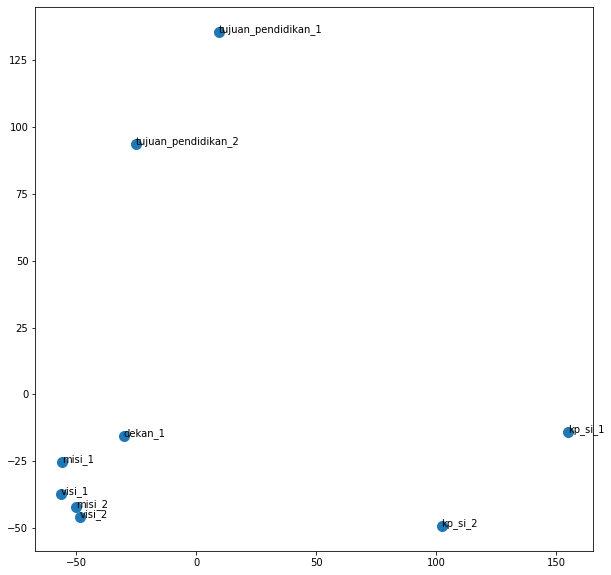

In [83]:
pca = PCA(n_components=2)
encoded_play_pca = pca.fit_transform(encoded_play)

plt.figure(figsize=(10,10))
plt.scatter(encoded_play_pca[:,0], encoded_play_pca[:,1], s=100)
for i, txt in enumerate(labels_words):
    plt.annotate(txt, (encoded_play_pca[i,0], encoded_play_pca[i,1]))

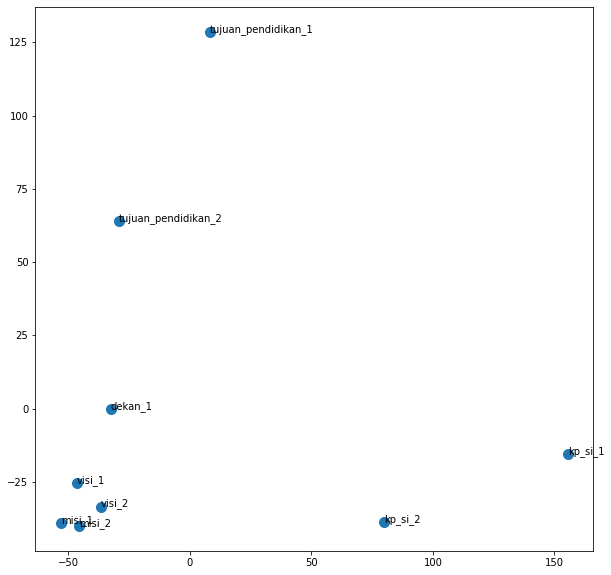

In [102]:
pca = PCA(n_components=2)
encoded_play_pca = pca.fit_transform(encoded_play)

plt.figure(figsize=(10,10))
plt.scatter(encoded_play_pca[:,0], encoded_play_pca[:,1], s=100)
for i, txt in enumerate(labels_words):
    plt.annotate(txt, (encoded_play_pca[i,0], encoded_play_pca[i,1]))

# Reset Cache

In [ ]:
import torch

torch.cuda.empty_cache()

print(torch.cuda.memory_summary(device=None, abbreviated=False))